# Import Libraries

In [1]:
!pip install vaderSentiment
!pip install wordcloud
!pip install plotly
!pip install TextBlob

%matplotlib inline
%precision 16
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from io import StringIO


     |████████████████████████████████| 125 kB 5.3 MB/s 


In [2]:
import plotly.graph_objects as go
import os
import itertools
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Importing the data

In [3]:
# Imports Dataset into Directory "/content/"
# Every time this line is ran, you must choose a file to import or else you may not move forward 
from google.colab import files
uploaded = files.upload()

Saving vaccination.csv to vaccination.csv


In [4]:
data = pd.read_csv("vaccination.csv")
data.head(3)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False


In [5]:
# Drop unnecessary columns
data = data [['user_location','user_created','date','text','hashtags','source','retweets','favorites','is_retweet']]
data.head()

,user_location,user_created,date,text,hashtags,source,retweets,favorites,is_retweet
0,"La Crescenta-Montrose, CA",2009-04-08 17:52:46,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,"San Francisco, CA",2009-09-21 15:27:30,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,Your Bed,2020-06-25 23:30:28,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,"Vancouver, BC - Canada",2008-09-10 11:28:53,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,NaN,2020-04-23 17:58:42,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [6]:
# Analyze dates of tweets.

data['tweet_date']=pd.to_datetime(data['date']).dt.date
tweet_date=data['tweet_date'].value_counts().to_frame().reset_index().rename(columns={'index':'date','tweet_date':'count'})
tweet_date['date']=pd.to_datetime(tweet_date['date'])
tweet_date=tweet_date.sort_values('date',ascending=False)
tweet_date.head(5)

,date,count
204,2021-11-23,472
162,2021-11-22,612
156,2021-11-21,629
121,2021-11-20,765
101,2021-11-19,846


In [7]:
# Visualize dates of tweets.

data['date_only']=pd.to_datetime(data['date']).dt.date
fig=go.Figure(go.Scatter(x=tweet_date['date'],y=tweet_date['count'],mode='markers+lines',name="Submissions",marker_color='dodgerblue'))

fig.update_layout(
    title_text='Tweets per Day : ({} - {}) '.format(data['date_only'].sort_values()[0].strftime("%d/%m/%Y"),
                                                       data['date_only'].sort_values().iloc[-1].strftime("%d/%m/%Y")), title_x=0.5,template="plotly_dark")

fig.show()

In [8]:
# Analyze the source that tweets were uploaded.

source=data['source'].value_counts().to_frame().reset_index().rename(columns={'index':'source','source':'count'})[:15]
source.head(5)

,source,count
0,Twitter for Android,58722
1,Twitter Web App,57119
2,Twitter for iPhone,49479
3,cowin_vaccine_app,11670
4,CowinAlertsBot,11276


In [9]:
# Visualize the source that tweets were uploaded.

fig = go.Figure(go.Bar(
    x=source['source'],y=source['count'],
    marker={'color': source['count'], 
    'colorscale': 'reds'},  
    text=source['count'],
    textposition = "inside",
))

fig.update_layout(title_text='Top Devices/Sources ',xaxis_title="Sources",yaxis_title="Count ",
                  template="plotly_dark",title_x=0.5)
fig.show()


In [10]:
# Analyze hashtags

hashtags=data['hashtags'].value_counts().to_frame().reset_index().rename(columns={'index':'hashtags','hashtags':'count'})[:15]
hashtags.head(5)

,hashtags,count
0,"['COVAXIN', 'BBMP']",11113
1,['COVAXIN'],10625
2,['Moderna'],10603
3,['Covaxin'],9773
4,['SputnikV'],5523


In [11]:
# Visualize hashtags.

fig = go.Figure(go.Bar(
    x=hashtags['hashtags'],y=hashtags['count'],
    marker={'color': hashtags['count'], 
    'colorscale': 'reds'},  
    text=hashtags['count'],
    textposition = "inside",
))

fig.update_layout(title_text='Top Hashtags ',xaxis_title="Hashtags",yaxis_title="Count ",
                  template="plotly_dark",title_x=0.5)
fig.show()

In [12]:
# Create functions to clean the tweets.

def clean_tag(string):
    text=re.sub('<.*?>','',string)
    return text
def clean_mention(text):
    line=re.sub(r'@\w+','',text)
    return line
def clean_hash(text):
    line=re.sub(r'#\w+','',text)
    return line
def clean_newline(string):
    text=re.sub('\n','',string)
    return text
def clean_url(string): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',string)
    return text
def clean_number(text):
    line=re.sub(r'[0-9]+','',text)
    return line
def clean_punct(text):
    line = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','',text)
    #string="".join(line)
    return line
def strip(string):
    line=re.sub('\s{2,}', ' ', string.strip())
    return line
def clean_words(string):
    line=re.sub(r'\bamp\b|\bthi\b|\bha\b',' ',string)
    return line


In [14]:
# Implement the text cleaning functions on my tweets data

data['text_clean']=data['text'].str.lower()
data['text_clean']=data['text_clean'].apply(lambda x:clean_tag(str(x)))
data['text_clean']=data['text_clean'].apply(lambda x:clean_mention(str(x)))
data['text_clean']=data['text_clean'].apply(lambda x:clean_hash(str(x)))
data['text_clean']=data['text_clean'].apply(lambda x:clean_newline(x))
data['text_clean']=data['text_clean'].apply(lambda x:clean_url(x))
data['text_clean']=data['text_clean'].apply(lambda x:clean_number(x))
data['text_clean']=data['text_clean'].apply(lambda x:clean_punct(x))
data['text_clean']=data['text_clean'].apply(lambda x:clean_words(x))
data['text_clean']=data['text_clean'].apply(lambda x:strip(x))

data['text']=data['text_clean']

In [15]:
# Plot the distribution of tweet length
data['text_length']=data['text_clean'].str.split().map(lambda x: len(x))
fig = go.Figure(data=go.Violin(y=data['text_length'], box_visible=True, line_color='black',
                               meanline_visible=True, fillcolor='royalblue ', opacity=0.6,
                               x0='Tweet Text Length '))

fig.update_layout(yaxis_zeroline=False,title="Distribution of Text length ",template='ggplot2')
fig.show()

Text(0.5, 1.0, 'Most Used Words')

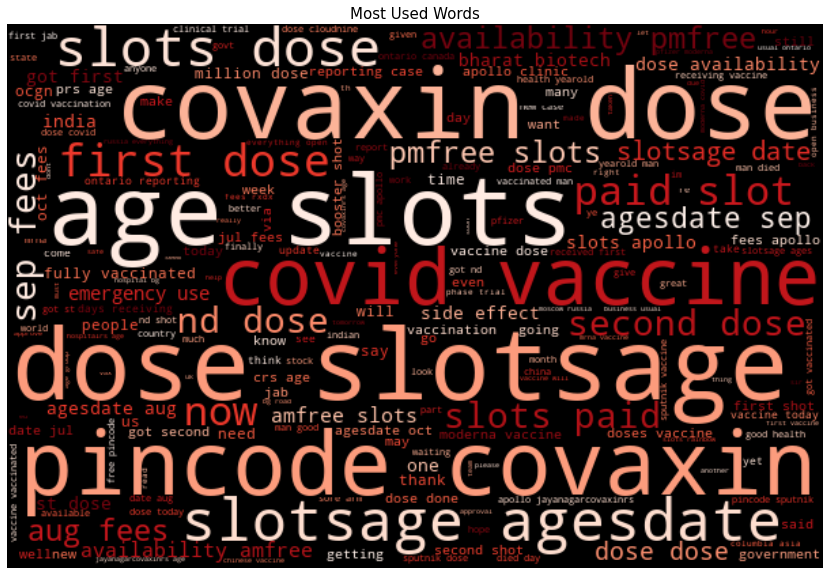

In [16]:
# Plot the most commonly used words in the tweets
fig, (ax1) = plt.subplots(1,1,figsize=[17, 10])
Common_words = WordCloud(background_color='black',colormap="Reds",  
                        width=600,height=400).generate(" ".join(data['text_clean']))

ax1.imshow(Common_words,interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Most Used Words',fontsize=15)

In [17]:
# Categorize the retweets as 0 or 1, where 0 means false and 1 means true.
data["retweets"] = data["retweets"].apply(lambda x: 1 if x > 0 else 0)

# Plot retweet chart. true or false?
retweet=data['retweets'].value_counts().to_frame().reset_index().rename(columns={'index':'retweets','retweets':'count'})[:15]
fig = go.Figure(go.Bar(
    x=retweet['retweets'],y=retweet['count'],
    marker={'color': retweet['count'], 
    'colorscale': 'reds'},  
    text=retweet['count'],
    textposition = "inside",
))

fig.update_layout(title_text='Retweets - True or False',xaxis_title="0 - False, 1 - True",yaxis_title="Count",
                  template="plotly_dark",title_x=0.5)
fig.show()

In [18]:
# Calculate subjectivity and polarity for sentiment analysis
data['text']=data['text_clean']
from textblob import TextBlob

# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
data['Subjectivity'] = data['text'].apply(getSubjectivity)
data['Polarity'] = data['text'].apply(getPolarity)

In [19]:
# Creating a function to define the three sentiments - negative, neutral, and positive
def Analysis(score):
 if score < 0:
  return 'Negative'
 elif score == 0:
  return 'Neutral'
 else:
  return 'Positive'

# Implement the function to assign sentiments
data['Analysis'] = data['Polarity'].apply(Analysis)

data.head()

,user_location,user_created,date,text,hashtags,source,retweets,favorites,is_retweet,tweet_date,date_only,text_clean,text_length,Subjectivity,Polarity,Analysis
0,"La Crescenta-Montrose, CA",2009-04-08 17:52:46,2020-12-20 06:06:44,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,2020-12-20,2020-12-20,same folks said daikon paste could treat a cyt...,10,0.125000,0.00,Neutral
1,"San Francisco, CA",2009-09-21 15:27:30,2020-12-13 16:27:13,while the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,2020-12-13,2020-12-13,while the world has been on the wrong side of ...,20,0.900000,-0.50,Negative
2,Your Bed,2020-06-25 23:30:28,2020-12-12 20:33:45,russian vaccine is created to last years…,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,2020-12-12,2020-12-12,russian vaccine is created to last years…,7,0.033333,0.00,Neutral
3,"Vancouver, BC - Canada",2008-09-10 11:28:53,2020-12-12 20:23:59,facts are immutable senator even when youre no...,NaN,Twitter Web App,1,2129,False,2020-12-12,2020-12-12,facts are immutable senator even when youre no...,18,0.550000,-0.05,Negative
4,NaN,2020-04-23 17:58:42,2020-12-12 20:17:19,explain to me again why we need a vaccine …,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,2020-12-12,2020-12-12,explain to me again why we need a vaccine …,10,0.000000,0.00,Neutral


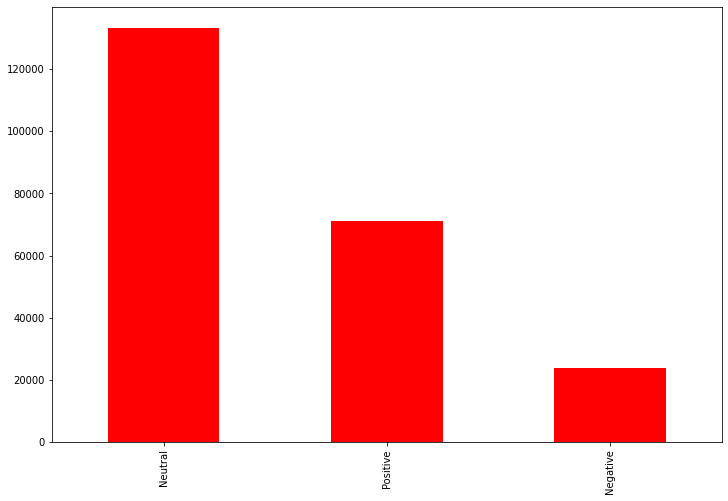

In [21]:
# Plot the sentiment results
data['Analysis'].value_counts().plot(kind='bar',figsize=(12,8),color= 'red');

In [22]:
!pip install sklearn
!pip install nltk
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
# Reclean text to get ready for prediction 

cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

data["text"] = data["text"].apply(cleanup)


# Assign test and train split with a test size of 20 percent.

train,test = train_test_split(data,test_size=0.2,random_state=42)
print((len(train), len(test)))

count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 4))

X_train_counts = count_vect.fit_transform(train["text"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = count_vect.transform(test["text"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["Analysis"]
y_test = test["Analysis"]

prediction = dict()

(182565, 45642)


In [27]:
# Implement multinomial naive bayes method to model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf) 

In [28]:
# Implement bernoulli naive bayes method to model
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

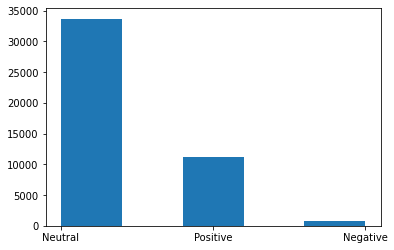

In [60]:
# Plot of Multinomial model predictions
plt.hist(prediction['Multinomial'], bins = 5);

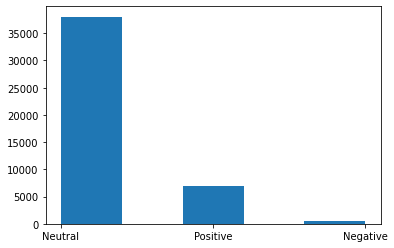

In [61]:
# Plot of Bernoulli model predictions
plt.hist(prediction['Bernoulli'], bins = 5);

In [62]:
# Count of errors in the Multinomial model
error_multinomial = sum(y_test != prediction['Multinomial'])
error_multinomial

8700

In [63]:
# Count of correctly labeled in the Multinomial model
correct_multinomial = sum(y_test == prediction['Multinomial'])
correct_multinomial

36942

In [64]:
# Accuracy of Multinomial model
correct_multinomial / (correct_multinomial + error_multinomial)

0.8093860917575917

In [58]:
# Count of errors in the Bernoulli model
error_bernoulli = sum(y_test != prediction['Bernoulli'])
error_bernoulli

12277

In [59]:
# Count of correctly labeled in the Bernoulli model
correct_bernoulli = sum(y_test == prediction['Bernoulli'])
correct_bernoulli

33365

In [65]:
# Accuracy of Multinomial model
correct_bernoulli / (correct_bernoulli + error_bernoulli)

0.7310152929319487